# **Monte Carlo Methods**

In this workshop, we will play Blackjack using Monte Carlo methods. To do this, we will be using the Gym Blackjack-v0 environment. 

Recall that Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over. The game is played against a fixed dealer whereby cards are converted into numerical values as follows:

* Numbered cards are accounted for at their face value
* Face cards (Jack, Queen, King) have value of 10
* Aces can either count as 11 or 1 (called 'usable' at 11).

The game starts with dealer having one face up and one face down card, while the player has two face up cards. The player can request additional cards (hit=1) until they decide to stop (stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater.  If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome is  decided by whose sum is closer to 21.  

In this environment, the reward for winning is +1, drawing is 0, and losing is -1.

As usual, we commence by installing the relevant packages.

In [1]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict

And now, we proceed to construct the environment.

In [2]:
env = gym.make('Blackjack-v0')

To show how this works, we can code a random policy where, as usual, the actions are random.

In [3]:
#Random Policy:
for i_episode in range(5):
    state = env.reset()
    while True:
        print(state)
        
        # takes random action from environment's action space
        action = env.action_space.sample() 

        # OpenAI gym gives feedback in this tuple form : state,reward,if_done?,other relevant info
        state, reward, done, info = env.step(action) 
        if done:
            print('Game has ended! Your Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(17, 4, False)
(19, 4, False)
Game has ended! Your Reward:  -1.0
You lost :(

(10, 4, False)
(19, 4, False)
Game has ended! Your Reward:  -1.0
You lost :(

(19, 5, True)
(19, 5, False)
Game has ended! Your Reward:  1.0
You won :)

(9, 10, False)
(15, 10, False)
Game has ended! Your Reward:  -1.0
You lost :(

(11, 10, False)
Game has ended! Your Reward:  -1.0
You lost :(



# **Monte Carlo Prediction**



We now look at Monte Carlo prediction to play Blackjack. To do this, we start by defining a probability of random choice. In this case we give 0 as output the probability of 0.2 whereas 1 as output is assigned 0.8.

In [4]:
np.random.choice([0,1], p=[0.2,0.8])

1

Having defined the probability, we can now define the episode setting. Here we start by reseting the environment with a stochastic random choice with probabilities defined as above. 

In [5]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset() #here, bj_env is the env instance
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In the code below we obtain the average prediction using the Monte Carlo probabilities. Note the Q-table is actually an average over the episodes.

In [6]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # Let us monitor our progress :)
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            
            
        # Generating an episode using our 80-20 policy we defined above:
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        '''
        This discounts array is the amount by which we wanna discount each consequent reward ie.
        discounts = [1,gamma, gamma^2, gamma^3.....] 
        then we compute the total return Gt= Rt+1 *1 + Rt+2 * gamma + Rt+3 * gamma^2 +...
        '''
        discounts = np.array([gamma**i for i in range(len(rewards)+1)]) 
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states): #ever-visit
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            #Just taking the mean of all the returns got by taking this action when we were in this state.
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

The line below just recovers the actual Q table using the code defined above

In [7]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)


Episode 500000/500000.

We can now plot our results for the state-value function. Note we have divided these into a usable and an unusable ace.

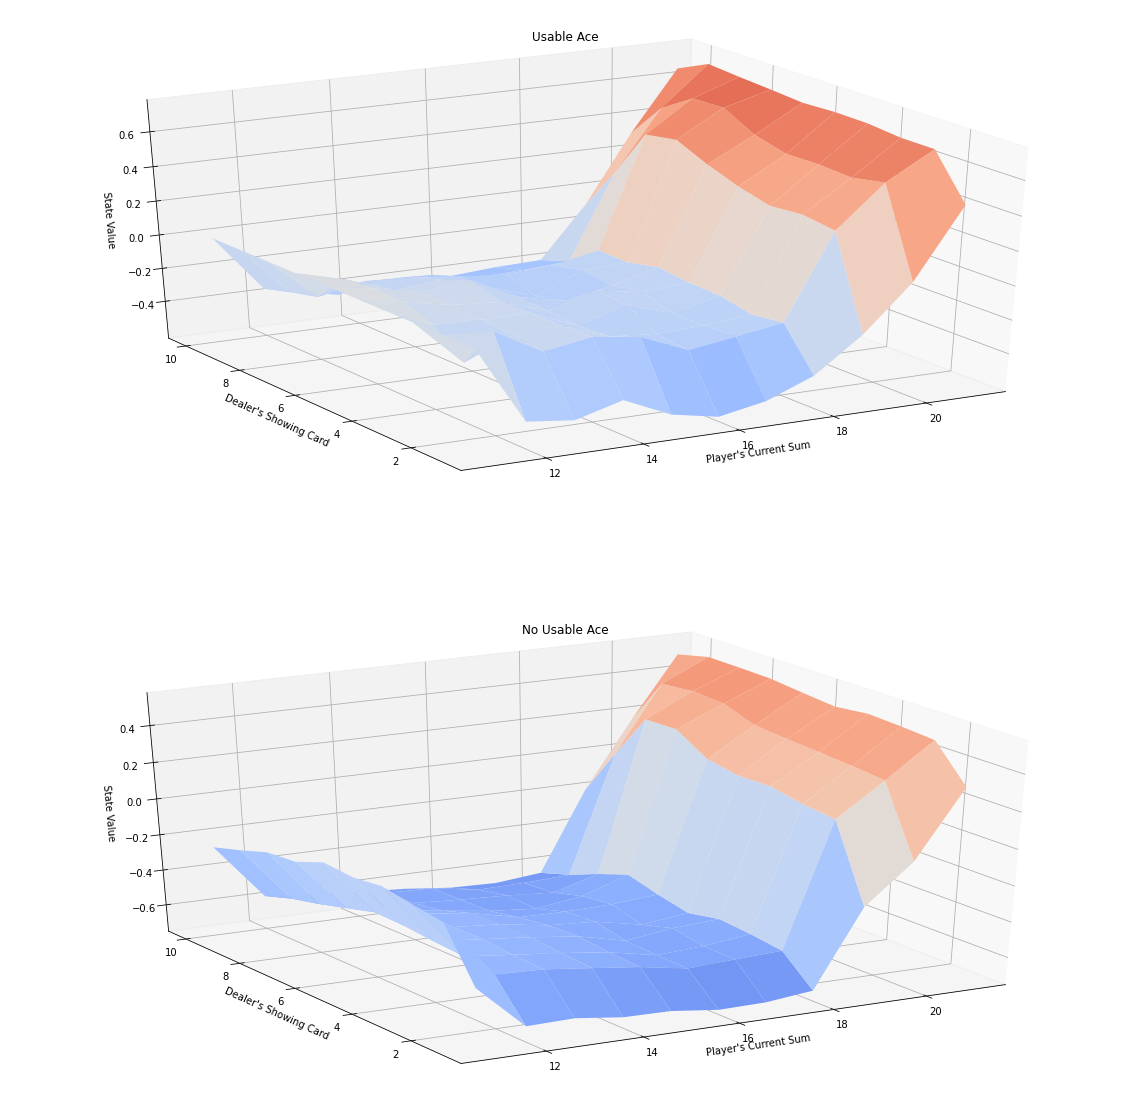

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()
    
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)    

The episode then becomes an epsilon-greedy one over the state-value function we computed earlier instead of an stochastic policy.

In [9]:
def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # obtains the action probabilities corresponding to epsilon-greedy policy
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s
  
''' 
Now we will use this get_probs func in generating the episode. 
Note that we are no longer using the stochastic policy we started with, instead building upon it in an epsilon greedy way.
'''
def generate_episode_from_Q(env, Q, epsilon, nA):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

''' 
Finally Q values are approximated by taking average of corresponding returns.
But instead we can write it using incremental mean and constant alpha.
As we are using constant alpha we need not keep a track of N-table, ie how many times we visited that state.
''' 

def update_Q(env, episode, Q, alpha, gamma):
    # updates the action-value function estimate using the most recent episode 
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

Note the Monte Carlo control sequence below. this is the actual implementation of the epsilon-greedy approach and the action-value updates at each episode.

In [10]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

With all the definitions in hand, we can obtain the policy and state-value functions. We also plot the values.

Episode 500000/500000.

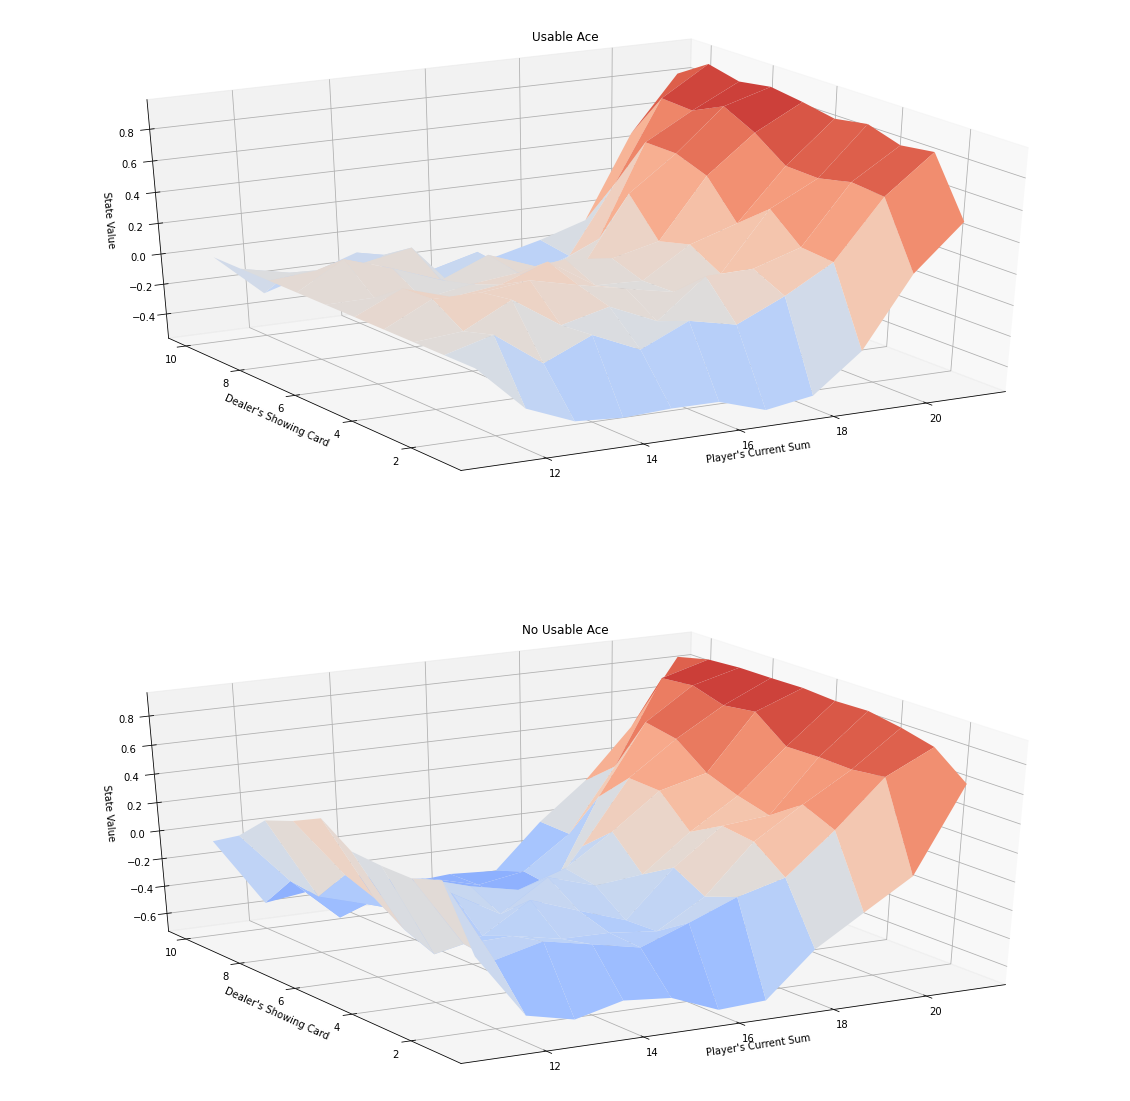

In [11]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.015)

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we plot the policy

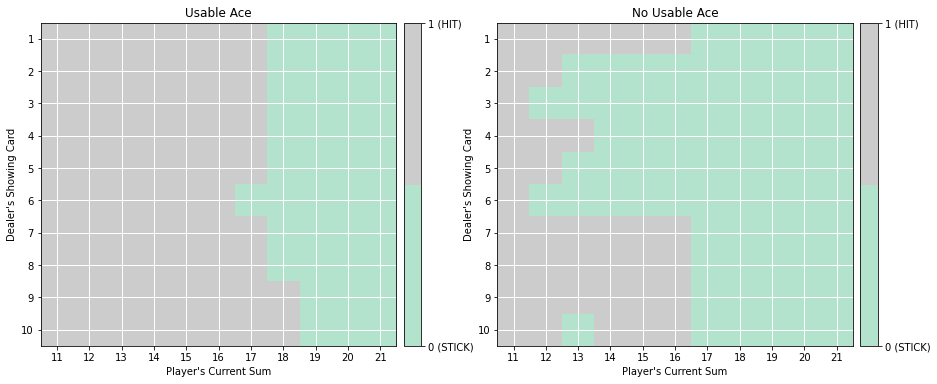

In [12]:
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

# plot the policy
plot_policy(policy)

and run ten episodes to test whether or not we can actually win, draw or loose.

In [13]:
nA=env.action_space.n
for i_episode in range(10):
    state = env.reset()
    while True:
        print(state)
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], 0, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        state = next_state
        if done:
            print('Game has ended! Your Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(8, 8, False)
(19, 8, True)
Game has ended! Your Reward:  1.0
You won :)

(13, 7, False)
Game has ended! Your Reward:  -1.0
You lost :(

(17, 2, False)
Game has ended! Your Reward:  0.0
You lost :(

(14, 10, False)
(18, 10, False)
Game has ended! Your Reward:  1.0
You won :)

(13, 6, False)
Game has ended! Your Reward:  -1.0
You lost :(

(17, 6, True)
Game has ended! Your Reward:  1.0
You won :)

(18, 10, False)
Game has ended! Your Reward:  -1.0
You lost :(

(20, 6, False)
Game has ended! Your Reward:  1.0
You won :)

(15, 6, False)
Game has ended! Your Reward:  -1.0
You lost :(

(7, 2, False)
Game has ended! Your Reward:  -1.0
You lost :(



Off policy


In [16]:
def create_random_policy(nA):
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(obs):
        return A
    return policy_fn
def create_greedy_action_policy(env,Q):

    def policy(obs):
        P = np.zeros_like(Q[obs], dtype=float)
        best_action = np.argmax(Q[obs])  #get best action
        P[best_action] = 1
        return P
    return policy

def Off_pol_mc_control_learn(env, num_episodes, policy, discount_factor):

    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedy policy 
    target_policy = create_greedy_action_policy(env,Q)
        
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            clear_output(wait=True)

        episode = []
        state = env.reset()
        for t in range(100):
            # Sample an action from our policy
            probs = target_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        G = 0.0

        W = 1.0

        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = discount_factor * G + reward

            C[state][action] += W
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])

            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./policy(state)[action]
        
    return Q, target_policy

In [18]:
from IPython.display import clear_output

In [19]:
env = gym.make('Blackjack-v0')
env.reset()
rand = create_random_policy(env.action_space.n)
Q_off_Pol,off_MC_Learned_Policy = Off_pol_mc_control_learn(env, 500000, rand,0.9)

Episode 500000/500000.

In [22]:
def calc_payoffs(env,rounds,players,pol):

    average_payouts = []
    for player in range(players):
        rd = 1
        total_payout = 0 # to store total payout over 'num_rounds'

        while rd <= rounds:
            action = np.argmax(pol(env._get_obs()))
            obs, payout, is_done, _ = env.step(action)
            if is_done:
                total_payout += payout
                env.reset() # Environment deals new cards to player and dealer
                rd += 1
        average_payouts.append(total_payout)

    plt.plot(average_payouts)                
    plt.xlabel('num_player')
    plt.ylabel('payout after ' + str(rounds) + 'rounds')
    plt.show()    
    print ("Average payout of a player after {} rounds is {}".format(rounds, sum(average_payouts)/players))

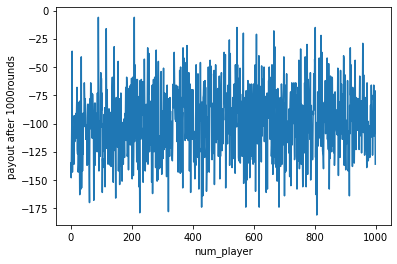

Average payout of a player after 1000 rounds is -99.247


In [23]:
#Payoff for Off-Policy MC Trained Policy
env.reset()
calc_payoffs(env,1000,1000,off_MC_Learned_Policy)

In [25]:
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

In [28]:
import gym
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm
from collections import defaultdict
from IPython.display import clear_output
%matplotlib inline

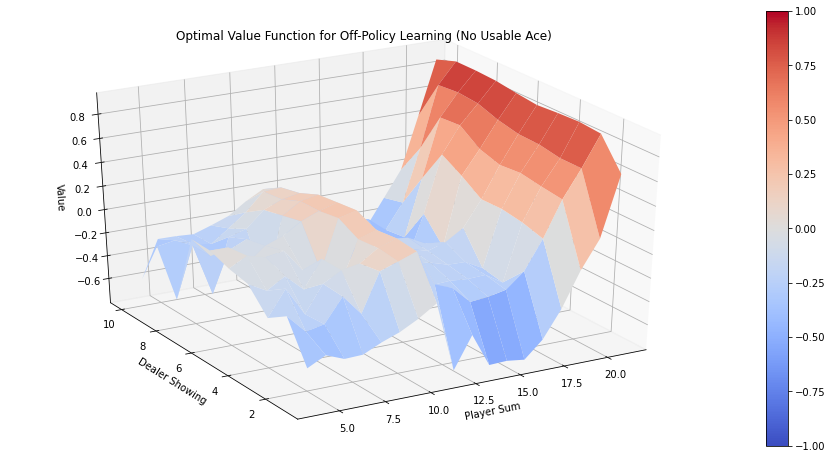

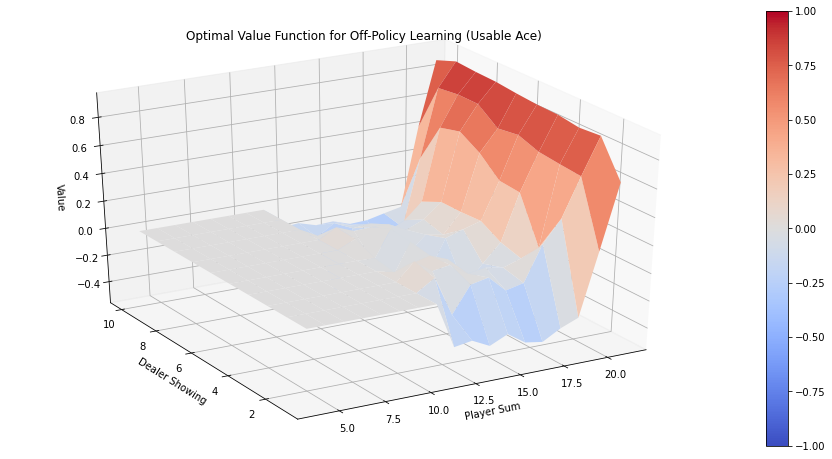

In [29]:
V = defaultdict(float)
for state, actions in Q_off_Pol.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function for Off-Policy Learning")

Off-Policy MC Learning Policy


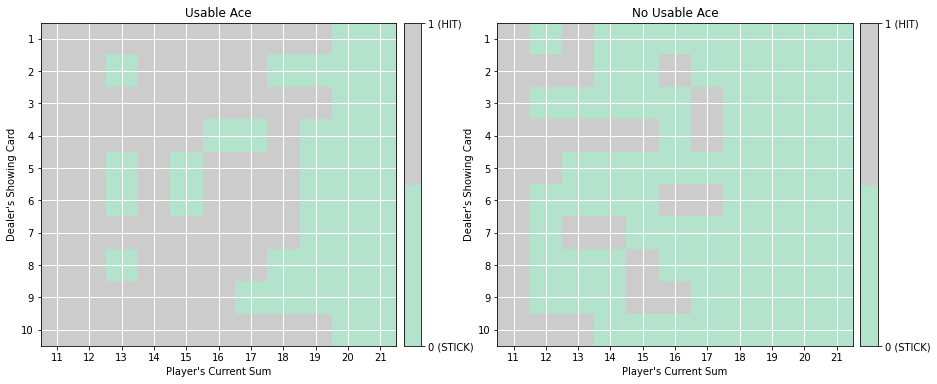

In [30]:
pol_test = {key: np.argmax(off_MC_Learned_Policy(key)) for key in Q_off_Pol.keys()}
print("Off-Policy MC Learning Policy")
plot_policy(pol_test)

In [31]:
nA=env.action_space.n
for i_episode in range(10):
    state = env.reset()
    while True:
        print(state)
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], 0, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        state = next_state
        if done:
            print('Game has ended! Your Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(13, 10, False)
Game has ended! Your Reward:  -1.0
You lost :(

(18, 8, False)
Game has ended! Your Reward:  1.0
You won :)

(15, 1, False)
Game has ended! Your Reward:  -1.0
You lost :(

(12, 3, False)
Game has ended! Your Reward:  -1.0
You lost :(

(21, 8, True)
Game has ended! Your Reward:  1.0
You won :)

(20, 3, False)
Game has ended! Your Reward:  1.0
You won :)

(20, 9, False)
Game has ended! Your Reward:  1.0
You won :)

(10, 10, False)
(20, 10, False)
Game has ended! Your Reward:  0.0
You lost :(

(12, 2, False)
(19, 2, False)
Game has ended! Your Reward:  1.0
You won :)

(17, 3, False)
Game has ended! Your Reward:  0.0
You lost :(

